In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter1d

In [2]:
def estimate_global_motion(prev_gray, curr_gray):
    """
    Estimate global motion between two consecutive frames using dense optical flow.
    """
    flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None,
                                        pyr_scale=0.5, levels=3, winsize=15,
                                        iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    flow_mean = np.mean(flow, axis=(0, 1))  # Estimate average motion (global translation)
    return flow_mean

In [3]:
def smooth_motion(motions, smoothing_radius=5):
    """
    Smooth the motion parameters using a simple moving average filter.
    """
    smoothed_motions = []
    for i in range(len(motions)):
        start = max(0, i - smoothing_radius)
        end = min(len(motions), i + smoothing_radius + 1)
        smoothed_motions.append(np.mean(motions[start:end], axis=0))
    return np.array(smoothed_motions)

In [4]:
def warp_frame(frame, translation):
    """
    Warp a frame using the given translation vector.
    """
    h, w = frame.shape[:2]
    transform_matrix = np.array([[1, 0, -translation[0]],
                                  [0, 1, -translation[1]]], dtype=np.float32)
    return cv2.warpAffine(frame, transform_matrix, (w, h))

In [5]:
def calculate_mse_psnr(original, stabilized):
    """
    Calculate Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) between two frames.
    """
    mse = np.mean((original - stabilized) ** 2)
    if mse == 0:
        return mse, float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return mse, psnr

In [6]:
def stabilize_video(input_path, output_path):
    """
    Stabilize the video and generate visualizations.
    """
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Error: Cannot open video.")
        return

    # Prepare video writer
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    # Read the first frame and initialize
    ret, prev_frame = cap.read()
    if not ret:
        print("Error: Cannot read video.")
        return

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    motions = []
    original_frames = []
    stabilized_frames = []
    mses = []
    psnrs = []

    while True:
        ret, curr_frame = cap.read()
        if not ret:
            break

        curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
        motion = estimate_global_motion(prev_gray, curr_gray)
        motions.append(motion)

        original_frames.append(curr_frame)
        prev_gray = curr_gray

    # Smooth the motion
    smoothed_motions = smooth_motion(motions)

    # Reset video and apply stabilization
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    for i, smoothed_motion in enumerate(smoothed_motions):
        ret, frame = cap.read()
        if not ret:
            break

        # Warp the frame based on smoothed motion
        stabilized_frame = warp_frame(frame, smoothed_motion)
        stabilized_frames.append(stabilized_frame)

        # Calculate MSE and PSNR
        mse, psnr = calculate_mse_psnr(cv2.cvtColor(original_frames[i], cv2.COLOR_BGR2GRAY),
                                       cv2.cvtColor(stabilized_frame, cv2.COLOR_BGR2GRAY))
        mses.append(mse)
        psnrs.append(psnr)

        out.write(stabilized_frame)

    cap.release()
    out.release()
    motions = np.array(motions)
    smoothed_motions = np.array(smoothed_motions)

    # Plot X and Y trajectories
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 2, 1)
    plt.plot(motions[:, 0], label='Original X Trajectory', color='royalblue')
    plt.plot(smoothed_motions[:, 0], label='Smoothed X Trajectory', color='darkorange')
    plt.title('X Trajectory')
    plt.xlabel('Frame')
    plt.ylabel('X Translation')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(motions[:, 1], label='Original Y Trajectory', color='royalblue')
    plt.plot(smoothed_motions[:, 1], label='Smoothed Y Trajectory', color='darkorange')
    plt.title('Y Trajectory')
    plt.xlabel('Frame')
    plt.ylabel('Y Translation')
    plt.legend()

    # Plot MSE
    plt.subplot(2, 2, 3)
    plt.plot(mses, label='MSE', color='green')
    plt.title('Mean Squared Error (MSE)')
    plt.xlabel('Frame')
    plt.ylabel('MSE')

    # Plot PSNR
    plt.subplot(2, 2, 4)
    plt.plot(psnrs, label='PSNR', color='orange')
    plt.title('Peak Signal-to-Noise Ratio (PSNR)')
    plt.xlabel('Frame')
    plt.ylabel('PSNR (dB)')

    plt.tight_layout()
    plt.show()

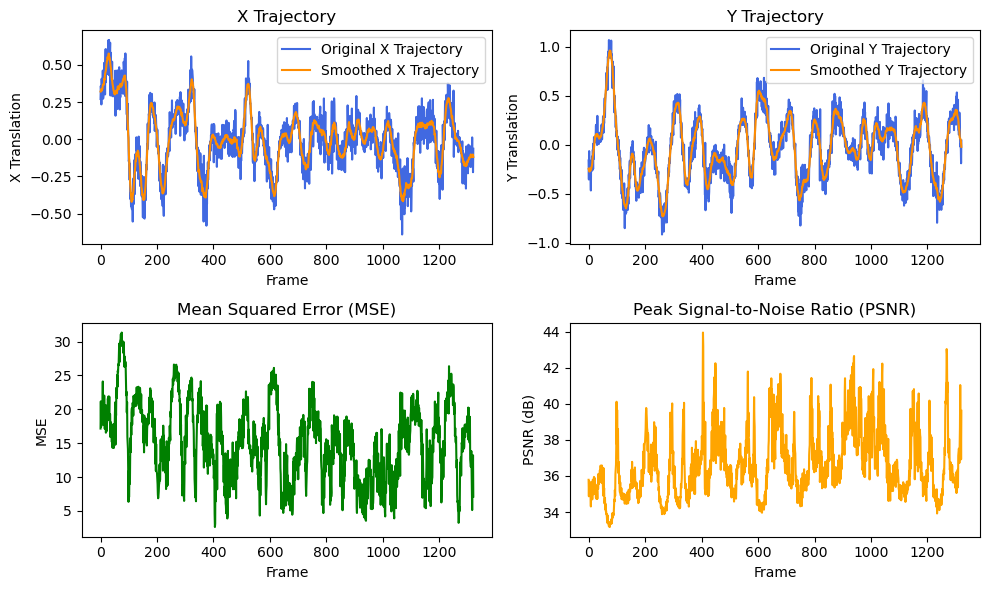

In [7]:
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\video.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_avg.mp4"
stabilize_video(input_video_path, output_video_path)

In [8]:
def estimate_global_motion(prev_gray, curr_gray):
    """
    Estimate global motion between two consecutive frames using dense optical flow.
    """
    flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None,
                                        pyr_scale=0.5, levels=3, winsize=15,
                                        iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    flow_mean = np.mean(flow, axis=(0, 1))  # Estimate average motion (global translation)
    return flow_mean

In [9]:
def warp_frame(frame, translation):
    """
    Warp a frame using the given translation vector.
    """
    h, w = frame.shape[:2]
    transform_matrix = np.array([[1, 0, -translation[0]],
                                  [0, 1, -translation[1]]], dtype=np.float32)
    return cv2.warpAffine(frame, transform_matrix, (w, h))

In [10]:
def calculate_mse_psnr(original, stabilized):
    """
    Calculate Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) between two frames.
    """
    mse = np.mean((original - stabilized) ** 2)
    if mse == 0:
        return mse, float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return mse, psnr

In [11]:
def median_filter_motion(motions, kernel_size=5):
    """
    Smooth the motion parameters using a median filter.
    """
    smoothed_motions = np.copy(motions)
    smoothed_motions[:, 0] = medfilt(motions[:, 0], kernel_size=kernel_size)
    smoothed_motions[:, 1] = medfilt(motions[:, 1], kernel_size=kernel_size)
    return smoothed_motions

In [12]:
def stabilize_video(input_path, output_path):
    """
    Stabilize the video and generate visualizations.
    """
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Error: Cannot open video.")
        return

    # Prepare video writer
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    # Read the first frame and initialize
    ret, prev_frame = cap.read()
    if not ret:
        print("Error: Cannot read video.")
        return

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    motions = []
    original_frames = []
    stabilized_frames = []
    mses = []
    psnrs = []

    # Estimate motion for each frame
    while True:
        ret, curr_frame = cap.read()
        if not ret:
            break

        curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
        motion = estimate_global_motion(prev_gray, curr_gray)
        motions.append(motion)

        original_frames.append(curr_frame)
        prev_gray = curr_gray

    motions = np.array(motions)
    # Smooth the motion using median filter
    smoothed_motions = median_filter_motion(motions, kernel_size=5)

    # Reset video and apply stabilization
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    for i, smoothed_motion in enumerate(smoothed_motions):
        ret, frame = cap.read()
        if not ret:
            break

        # Warp the frame based on smoothed motion
        stabilized_frame = warp_frame(frame, smoothed_motion)
        stabilized_frames.append(stabilized_frame)

        # Calculate MSE and PSNR
        mse, psnr = calculate_mse_psnr(cv2.cvtColor(original_frames[i], cv2.COLOR_BGR2GRAY),
                                       cv2.cvtColor(stabilized_frame, cv2.COLOR_BGR2GRAY))
        mses.append(mse)
        psnrs.append(psnr)

        out.write(stabilized_frame)

    cap.release()
    out.release()
    print("Stabilization complete. Video saved to:", output_path)

    # Plot Trajectories and Metrics
    plt.figure(figsize=(10, 6))

    # X Trajectory
    plt.subplot(2, 2, 1)
    plt.plot(motions[:, 0], label='Original X Trajectory', color='royalblue')
    plt.plot(smoothed_motions[:, 0], label='Smoothed X Trajectory', color='darkorange')
    plt.title('X Trajectory')
    plt.xlabel('Frame')
    plt.ylabel('X Translation')
    plt.legend()

    # Y Trajectory
    plt.subplot(2, 2, 2)
    plt.plot(motions[:, 1], label='Original Y Trajectory', color='royalblue')
    plt.plot(smoothed_motions[:, 1], label='Smoothed Y Trajectory', color='darkorange')
    plt.title('Y Trajectory')
    plt.xlabel('Frame')
    plt.ylabel('Y Translation')
    plt.legend()

    # Plot MSE
    plt.subplot(2, 2, 3)
    plt.plot(mses, label='MSE', color='green')
    plt.title('Mean Squared Error (MSE)')
    plt.xlabel('Frame')
    plt.ylabel('MSE')

    # Plot PSNR
    plt.subplot(2, 2, 4)
    plt.plot(psnrs, label='PSNR', color='orange')
    plt.title('Peak Signal-to-Noise Ratio (PSNR)')
    plt.xlabel('Frame')
    plt.ylabel('PSNR (dB)')

    plt.tight_layout()
    plt.show()


Stabilization complete. Video saved to: E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_median.mp4


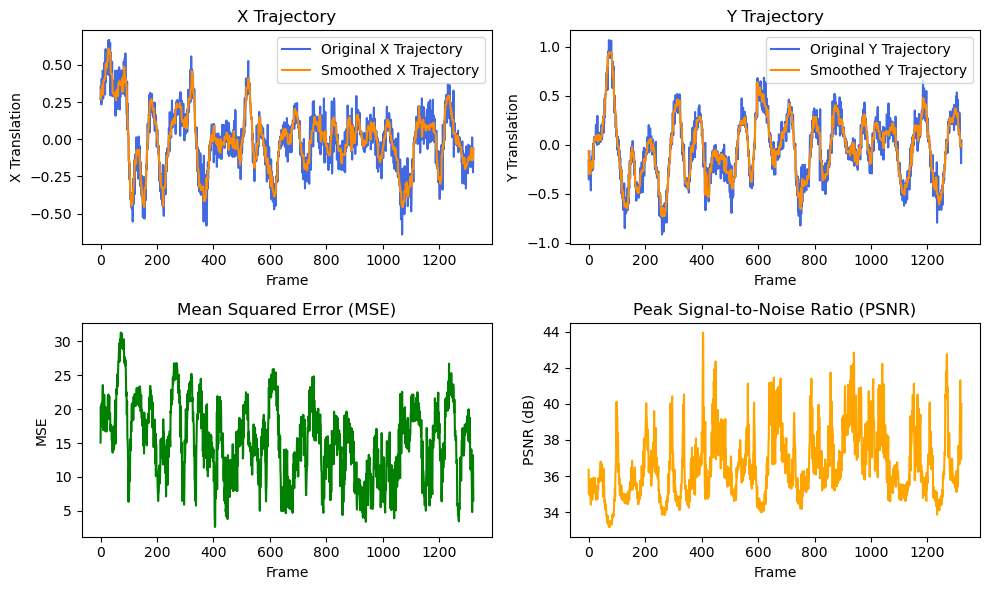

In [13]:
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\video.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_median.mp4"
stabilize_video(input_video_path, output_video_path)

In [14]:
def gaussian_filter_motion(motions, sigma=2):
    """
    Smooth the motion parameters using a Gaussian filter.
    """
    smoothed_motions = np.copy(motions)
    smoothed_motions[:, 0] = gaussian_filter1d(motions[:, 0], sigma=sigma)
    smoothed_motions[:, 1] = gaussian_filter1d(motions[:, 1], sigma=sigma)
    return smoothed_motions

In [15]:
def warp_frame(frame, translation):
    """
    Warp a frame using the given translation vector.
    """
    h, w = frame.shape[:2]
    transform_matrix = np.array([[1, 0, -translation[0]],
                                  [0, 1, -translation[1]]], dtype=np.float32)
    return cv2.warpAffine(frame, transform_matrix, (w, h))

In [16]:
def calculate_mse_psnr(original, stabilized):
    """
    Calculate Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) between two frames.
    """
    mse = np.mean((original - stabilized) ** 2)
    if mse == 0:
        return mse, float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return mse, psnr

In [17]:
def stabilize_video(input_path, output_path):
    """
    Stabilize the video and generate visualizations.
    """
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Error: Cannot open video.")
        return

    # Prepare video writer
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    # Read the first frame and initialize
    ret, prev_frame = cap.read()
    if not ret:
        print("Error: Cannot read video.")
        return

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    motions = []
    original_frames = []
    stabilized_frames = []
    mses = []
    psnrs = []

    # Estimate motion for each frame
    while True:
        ret, curr_frame = cap.read()
        if not ret:
            break

        curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
        motion = estimate_global_motion(prev_gray, curr_gray)
        motions.append(motion)

        original_frames.append(curr_frame)
        prev_gray = curr_gray

    motions = np.array(motions)
    # Smooth the motion using Gaussian filter
    smoothed_motions = gaussian_filter_motion(motions, sigma=2)

    # Reset video and apply stabilization
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    for i, smoothed_motion in enumerate(smoothed_motions):
        ret, frame = cap.read()
        if not ret:
            break

        # Warp the frame based on smoothed motion
        stabilized_frame = warp_frame(frame, smoothed_motion)
        stabilized_frames.append(stabilized_frame)

        # Calculate MSE and PSNR
        mse, psnr = calculate_mse_psnr(cv2.cvtColor(original_frames[i], cv2.COLOR_BGR2GRAY),
                                       cv2.cvtColor(stabilized_frame, cv2.COLOR_BGR2GRAY))
        mses.append(mse)
        psnrs.append(psnr)

        out.write(stabilized_frame)

    cap.release()
    out.release()
    print("Stabilization complete. Video saved to:", output_path)

    # Plot Trajectories and Metrics
    plt.figure(figsize=(10, 6))

    # X Trajectory
    plt.subplot(2, 2, 1)
    plt.plot(motions[:, 0], label='Original X Trajectory', color='royalblue')
    plt.plot(smoothed_motions[:, 0], label='Smoothed X Trajectory', color='darkorange')
    plt.title('X Trajectory')
    plt.xlabel('Frame')
    plt.ylabel('X Translation')
    plt.legend()

    # Y Trajectory
    plt.subplot(2, 2, 2)
    plt.plot(motions[:, 1], label='Original Y Trajectory', color='royalblue')
    plt.plot(smoothed_motions[:, 1], label='Smoothed Y Trajectory', color='darkorange')
    plt.title('Y Trajectory')
    plt.xlabel('Frame')
    plt.ylabel('Y Translation')
    plt.legend()

    # Plot MSE
    plt.subplot(2, 2, 3)
    plt.plot(mses, label='MSE', color='green')
    plt.title('Mean Squared Error (MSE)')
    plt.xlabel('Frame')
    plt.ylabel('MSE')

    # Plot PSNR
    plt.subplot(2, 2, 4)
    plt.plot(psnrs, label='PSNR', color='orange')
    plt.title('Peak Signal-to-Noise Ratio (PSNR)')
    plt.xlabel('Frame')
    plt.ylabel('PSNR (dB)')

    plt.tight_layout()
    plt.show()


Stabilization complete. Video saved to: E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_gaussian.mp4


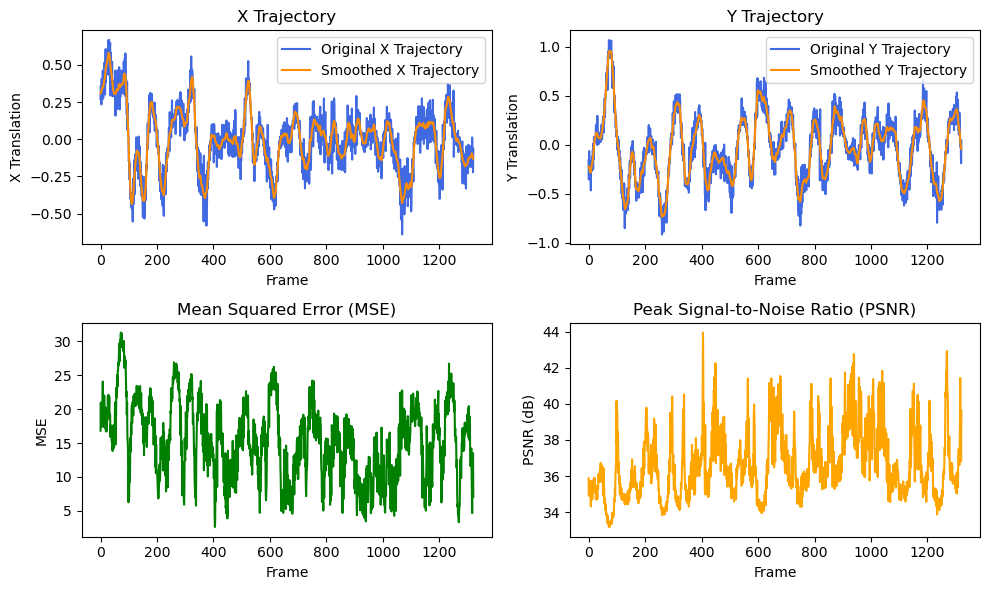

In [18]:
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\video.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_gaussian.mp4"
stabilize_video(input_video_path, output_video_path)